## Compare classification with different 1D DCT functions

In [1]:
import numpy as np
import utils.makeDataset as DatasetMaker
from utils.training import show_confusion_matrix, unique_images, get_average_dct, save_model_and_label_encoder
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import os

In [2]:
OUTPUT_DATA_FOLDER = '../output/datasets/'
INPUT_DATA_FOLDER = '../data/'

# DATASETS = ["d1_Q10", "d2_Q10", "d3_Q10"]  # Q90 with d1 d2 d3 and random roundings
DATASETS = [19, 20, 21]  # Q90 with d1 d2 d3 and random roundings

MODEL_CATEGORY = "d_Q90"
BL_COMPUTE_AVG = False

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

MODELS = {
    "rf": RandomForestClassifier(max_depth=10, random_state=0),
    "adaboost": AdaBoostClassifier(),
    "svm": make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True)),
    "naive_bayes": GaussianNB()
}

### Loading data and preprocessing

In [4]:
from sklearn import preprocessing

X = []
y_labels = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y_labels += [current_dataset] * len(X_current)
    if BL_COMPUTE_AVG:
        X += get_average_dct(X_current)
    else:
        X += X_current

le = preprocessing.LabelEncoder()
y = le.fit_transform(y_labels)

new_X, new_y = unique_images(X, y.tolist())

### Cross val predict for each model to test

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       233
           1       0.92      0.91      0.91       233
           2       0.95      0.91      0.93       233

    accuracy                           0.93       699
   macro avg       0.93      0.93      0.93       699
weighted avg       0.93      0.93      0.93       699



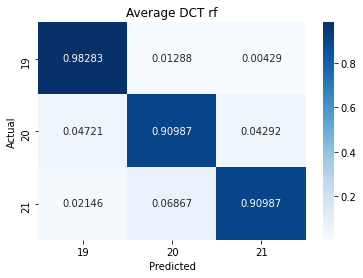

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       233
           1       0.59      0.68      0.63       233
           2       0.69      0.53      0.60       233

    accuracy                           0.72       699
   macro avg       0.72      0.72      0.72       699
weighted avg       0.72      0.72      0.72       699



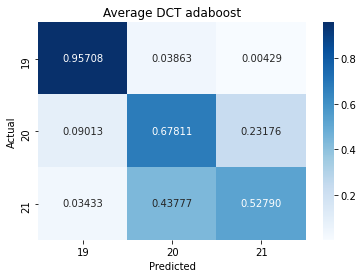

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       233
           1       0.64      0.65      0.65       233
           2       0.71      0.64      0.67       233

    accuracy                           0.75       699
   macro avg       0.75      0.75      0.75       699
weighted avg       0.75      0.75      0.75       699



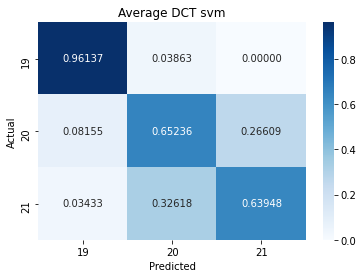

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       233
           1       0.82      0.81      0.82       233
           2       0.89      0.91      0.90       233

    accuracy                           0.87       699
   macro avg       0.87      0.87      0.87       699
weighted avg       0.87      0.87      0.87       699



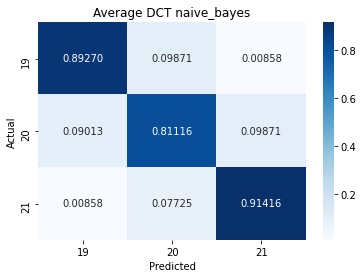

In [5]:
from sklearn.model_selection import cross_val_predict

for model in MODELS.keys():
    y_pred = cross_val_predict(MODELS[model], new_X, new_y, cv=5)
    print(classification_report(new_y, y_pred))
    show_confusion_matrix(new_y, y_pred, DATASETS, f"Average DCT {model}")

## Other way to split data and manual cross validation

In [6]:
import pandas as pd

def coef_dct(folder):
    """ compute average DCT of all images (with DC coefficient=0) in the given folder
    param folder : folder containing the images
    param order : order for vectorization of the DCT matrix ('zigzag' or 'simple')
    return avg_dct : list of average DCT"""
    img_blocks = os.listdir(folder)
    avg_dct = [np.load(folder + img_block) for img_block in img_blocks if img_block.endswith('.npy')]
    # avg_dct = np.mean(np.array(dct_blocks), axis=1)
    for x in avg_dct:
        x[0] = 0
    return avg_dct


def train_test(input_folder, nb_dataset, train_size=0.7, order='zigzag'):
    """ split images in the folders given by nb_dataset into train and test sets
    param input_folder : directory containing all the datasets
    param nb_dataset : list of numbers of datasets to perform on
    param train_size : size of training set
    param order : order for vectorization of the DCT matrix ('zigzag' or 'simple')
    return df_train, df_test : dataframes of train and test sets"""
    n = len(os.listdir(input_folder + str(nb_dataset[0]))) - 1
    index = list(np.arange(n))
    np.random.shuffle(index)
    train_index = index[:int((n + 1) * train_size)]
    test_index = index[int((n + 1) * train_size):]
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for i in nb_dataset:
        dct_ = coef_dct(input_folder + str(i) + "/")
        df_train = df_train.append([[list(x), i] for ind, x in enumerate(dct_) if ind in train_index])
        df_test = df_test.append([[list(x), i] for ind, x in enumerate(dct_) if ind in test_index])

    df_train = df_train.reset_index(drop=True)
    df_train = df_train.rename(columns={0: 'average_dct', 1: 'class'})

    df_test = df_test.reset_index(drop=True)
    df_test = df_test.rename(columns={0: 'average_dct', 1: 'class'})
    # shuffle
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)
    return df_train, df_test


def cross_validation(input_folder, nb_dataset, n_splits, clf, order='zigzag'):
    n = len(os.listdir(input_folder + str(nb_dataset[0]))) - 1
    index = list(np.arange(n))
    np.random.shuffle(index)
    split_size = int(n / n_splits)
    scores = []
    for i in range(n_splits):
        test_index = index[i * split_size:(i + 1) * split_size]
        train_index = [x for x in index if x not in test_index]
        df_train = pd.DataFrame()
        df_test = pd.DataFrame()
        for i in nb_dataset:
            dct_ = coef_dct(input_folder + str(i) + "/")
            df_train = df_train.append([[list(x), i] for ind, x in enumerate(dct_) if ind in train_index])
            df_test = df_test.append([[list(x), i] for ind, x in enumerate(dct_) if ind in test_index])

        df_train = df_train.reset_index(drop=True)
        df_train = df_train.rename(columns={0: 'average_dct', 1: 'class'})
        df_test = df_test.reset_index(drop=True)
        df_test = df_test.rename(columns={0: 'average_dct', 1: 'class'})
        df_train = df_train.sample(frac=1).reset_index(drop=True)
        df_test = df_test.sample(frac=1).reset_index(drop=True)

        X_train, X_test, y_train, y_test = np.array([e for e in df_train['average_dct']]), np.array(
            [e for e in df_test['average_dct']]), df_train['class'], df_test['class']
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))

    return np.mean(np.array(scores))

In [7]:
folders = [19, 20, 21]

# Train _test split for scoring
# train, test = train_test(OUTPUT_DATA_FOLDER, folders)
#
# X_train, X_test, y_train, y_test = np.array([e for e in train['average_dct']]), np.array(
#     [e for e in test['average_dct']]), train['class'], test['class']
rfc = RandomForestClassifier(max_depth=10, criterion='entropy', random_state=0)

# Cross validation
score_cv = cross_validation(OUTPUT_DATA_FOLDER, folders, 5, rfc, order='zigzag')
print(score_cv)

0.8474820143884892


## Train and save best model

In [8]:
# DATASETS = ["d1_Q90", "d2_Q90", "d3_Q90"]  # Q90 with d1 d2 d3 and random roundings
# MODEL_CATEGORY = "d_Q90"
#
#
# MODEL_TYPE = "rf"
# PATH_MODELS = f"../models/final_models/{MODEL_CATEGORY}/"
# MODEL_NAME = ''.join([str(MODEL_TYPE)] + ['_' + str(curr) for curr in DATASETS])
# model = MODELS[MODEL_TYPE]
#
# X = []
# y_labels = []
#
# for current_dataset in DATASETS:
#     _, X_current = DatasetMaker.load_dataset(current_dataset)
#     y_labels += [current_dataset] * len(X_current)
#     if BL_COMPUTE_AVG:
#         X += get_average_dct(X_current)
#     else:
#         X += X_current
#
# le = preprocessing.LabelEncoder()
# y = le.fit_transform(y_labels)


In [9]:
# model.fit(X, y)
# save_model_and_label_encoder(model, le, PATH_MODELS, MODEL_NAME)